<a href="https://colab.research.google.com/github/mingun0112/Dacon/blob/main/ComputerVisionAnomalyDetection/Baseline_epoch40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:


import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/open.zip'

Archive:  /content/drive/MyDrive/open.zip
  inflating: open/sample_submission.csv  
 extracting: open/test.zip           
  inflating: open/test_df.csv        
 extracting: open/train.zip          
  inflating: open/train_df.csv       


In [4]:
!dir

drive  open  sample_data


In [3]:
!unzip '/content/open/train.zip'

Archive:  /content/open/train.zip
  inflating: train/10000.png         
  inflating: train/10001.png         
  inflating: train/10002.png         
  inflating: train/10003.png         
  inflating: train/10004.png         
  inflating: train/10005.png         
  inflating: train/10006.png         
  inflating: train/10007.png         
  inflating: train/10008.png         
  inflating: train/10009.png         
  inflating: train/10010.png         
  inflating: train/10011.png         
  inflating: train/10012.png         
  inflating: train/10013.png         
  inflating: train/10014.png         
  inflating: train/10015.png         
  inflating: train/10016.png         
  inflating: train/10017.png         
  inflating: train/10018.png         
  inflating: train/10019.png         
  inflating: train/10020.png         
  inflating: train/10021.png         
  inflating: train/10022.png         
  inflating: train/10023.png         
  inflating: train/10024.png         
  inflating: tra

In [4]:
!unzip '/content/open/test.zip'

Archive:  /content/open/test.zip
  inflating: test/20000.png          
  inflating: test/20001.png          
  inflating: test/20002.png          
  inflating: test/20003.png          
  inflating: test/20004.png          
  inflating: test/20005.png          
  inflating: test/20006.png          
  inflating: test/20007.png          
  inflating: test/20008.png          
  inflating: test/20009.png          
  inflating: test/20010.png          
  inflating: test/20011.png          
  inflating: test/20012.png          
  inflating: test/20013.png          
  inflating: test/20014.png          
  inflating: test/20015.png          
  inflating: test/20016.png          
  inflating: test/20017.png          
  inflating: test/20018.png          
  inflating: test/20019.png          
  inflating: test/20020.png          
  inflating: test/20021.png          
  inflating: test/20022.png          
  inflating: test/20023.png          
  inflating: test/20024.png          
  inflating: test

In [8]:
from glob import glob
import pandas as pd
import numpy as np 
from tqdm import tqdm
import cv2

In [7]:
train_png = sorted(glob('train/*.png'))
test_png = sorted(glob('test/*.png'))

In [8]:
train_y = pd.read_csv("open/train_df.csv")

train_labels = train_y["label"]

label_unique = sorted(np.unique(train_labels))
print(label_unique)
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}
print(label_unique)
train_labels = [label_unique[k] for k in train_labels]
print(train_labels)

['bottle-broken_large', 'bottle-broken_small', 'bottle-contamination', 'bottle-good', 'cable-bent_wire', 'cable-cable_swap', 'cable-combined', 'cable-cut_inner_insulation', 'cable-cut_outer_insulation', 'cable-good', 'cable-missing_cable', 'cable-missing_wire', 'cable-poke_insulation', 'capsule-crack', 'capsule-faulty_imprint', 'capsule-good', 'capsule-poke', 'capsule-scratch', 'capsule-squeeze', 'carpet-color', 'carpet-cut', 'carpet-good', 'carpet-hole', 'carpet-metal_contamination', 'carpet-thread', 'grid-bent', 'grid-broken', 'grid-glue', 'grid-good', 'grid-metal_contamination', 'grid-thread', 'hazelnut-crack', 'hazelnut-cut', 'hazelnut-good', 'hazelnut-hole', 'hazelnut-print', 'leather-color', 'leather-cut', 'leather-fold', 'leather-glue', 'leather-good', 'leather-poke', 'metal_nut-bent', 'metal_nut-color', 'metal_nut-flip', 'metal_nut-good', 'metal_nut-scratch', 'pill-color', 'pill-combined', 'pill-contamination', 'pill-crack', 'pill-faulty_imprint', 'pill-good', 'pill-pill_type',

In [17]:
batch_size = 32
img_height = 180
img_width = 180

In [18]:
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (256, 256))
    return img

In [19]:
train_imgs = [img_load(m) for m in tqdm(train_png)]
test_imgs = [img_load(n) for n in tqdm(test_png)]

100%|██████████| 2154/2154 [01:11<00:00, 30.13it/s]


In [5]:
pip install timm


     |████████████████████████████████| 431 kB 5.4 MB/s 


In [31]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [6]:
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import pandas as pd
import numpy as np 
from tqdm import tqdm
import cv2

import os
import timm
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, accuracy_score
import time


device = torch.device('cuda')

In [30]:
class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode=mode
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img = self.img_paths[idx]
        if self.mode=='train':
            augmentation = random.randint(0,2)
            if augmentation==1:
                img = img[::-1].copy()
            elif augmentation==2:
                img = img[:,::-1].copy()
        img = transforms.ToTensor()(img)
        if self.mode=='test':
            pass
        
        label = self.labels[idx]
        return img, label
    
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.model = timm.create_model('efficientnetv2-b0', pretrained=True, num_classes=88)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
'efficientnetv2-b0

In [28]:
batch_size = 32
epochs = 40

# Train
train_dataset = Custom_dataset(np.array(train_imgs), np.array(train_labels), mode='train')
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

# Test
test_dataset = Custom_dataset(np.array(test_imgs), np.array(["tmp"]*len(test_imgs)), mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [22]:
def score_function(real, pred):
    score = f1_score(real, pred, average="macro")
    return score

model = Network().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler() 



best=0
for epoch in range(epochs):
    start=time.time()
    train_loss = 0
    train_pred=[]
    train_y=[]
    model.train()
    for batch in (train_loader):
        optimizer.zero_grad()
        x = torch.tensor(batch[0], dtype=torch.float32, device=device)
        y = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        loss = criterion(pred, y)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
        
    
    train_f1 = score_function(train_y, train_pred)

    TIME = time.time() - start
    print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')

epoch : 1/25    time : 68s/1632s
TRAIN    loss : 1.00241    f1 : 0.23944
epoch : 2/25    time : 68s/1564s
TRAIN    loss : 0.52811    f1 : 0.40142
epoch : 3/25    time : 67s/1478s
TRAIN    loss : 0.41671    f1 : 0.49174
epoch : 4/25    time : 67s/1409s
TRAIN    loss : 0.31137    f1 : 0.60825
epoch : 5/25    time : 68s/1353s
TRAIN    loss : 0.26980    f1 : 0.65906
epoch : 6/25    time : 69s/1303s
TRAIN    loss : 0.23588    f1 : 0.68522
epoch : 7/25    time : 67s/1208s
TRAIN    loss : 0.19404    f1 : 0.74215
epoch : 8/25    time : 67s/1139s
TRAIN    loss : 0.19473    f1 : 0.77006
epoch : 9/25    time : 68s/1088s
TRAIN    loss : 0.14741    f1 : 0.80970
epoch : 10/25    time : 67s/1005s
TRAIN    loss : 0.13456    f1 : 0.82469
epoch : 11/25    time : 67s/943s
TRAIN    loss : 0.11935    f1 : 0.84550
epoch : 12/25    time : 67s/876s
TRAIN    loss : 0.11324    f1 : 0.87683
epoch : 13/25    time : 67s/806s
TRAIN    loss : 0.09656    f1 : 0.87421
epoch : 14/25    time : 67s/738s
TRAIN    loss : 0

In [23]:
model.eval()
f_pred = []

with torch.no_grad():
    for batch in (test_loader):
        x = torch.tensor(batch[0], dtype = torch.float32, device = device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        f_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())

In [24]:
label_decoder = {val:key for key, val in label_unique.items()}

f_result = [label_decoder[result] for result in f_pred]

In [25]:
submission = pd.read_csv("open/sample_submission.csv")

submission["label"] = f_result

submission

,index,label
0,0,tile-glue_strip
1,1,cable-missing_cable
2,2,cable-missing_cable
3,3,cable-missing_cable
4,4,tile-good
...,...,...
2149,2149,tile-gray_stroke
2150,2150,screw-good
2151,2151,grid-good
2152,2152,cable-missing_cable


In [26]:
submission.to_csv("baseline_epoch40.csv", index = False)

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for labels in train_labels:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(train_imgs[i])
    #plt.title(class_names[labels[i]])
    plt.axis("off")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
 14%|█▍        | 597/4277 [06:20<39:03,  1.57it/s]


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f31cba05680> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f31cba0f170> (for post_execute):


KeyboardInterrupt: ignored

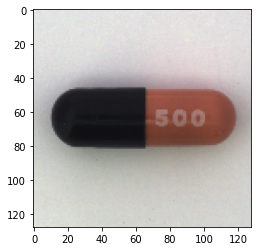